In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lmfit import Model
import matplotlib.ticker as ticker

In [3]:
# Functions

def line(x, m, b):
    return x * m + b

def tlm(s, r_s, N, w, L, r_c):
    return ((r_s * s) / (2 * N * (w + L + s) - L - s)) + (2 * r_c)

def tlm2(s, r_s, N, w, L, l_t):
    return (r_s / (2 * N * (w + L + s) - L - s)) * (s + 2 * l_t)

def w_contact(s, N, w, L):
    return (2 * N * (w + L + s)) - L - s

In [4]:
# Models

line_mod = Model(line)
line_params = line_mod.make_params(m = 1, b = 1)

# Considering L_t to get \rho_c Contact Resistivity
tlm_mod2 = Model(tlm2)
tlm2_params = tlm_mod2.make_params()
tlm2_params['r_s'].set(value = 1e6)
tlm2_params['N'].set(value = 60, vary = False)
tlm2_params['w'].set(value = 5e-4, vary = False)
tlm2_params['L'].set(value = 3200e-4, vary = False)
tlm2_params['l_t'].set(value = 1e-5, min = 0)

In [5]:
# Settings

col = ['Potential (V)', 'Current (A)', 'Time (s)']
col2 = ['Structure', 'Spacing (cm)', 'Resistance ($\Omega$)']
idea2 = {'P01': 2e-4,
         'P02': 5e-4,
         'P03': 10e-4,
         'P04' : 20e-4
         }

formatter = ticker.FuncFormatter(lambda x, pos: "{:.1f}".format(x / 1e6))
formatter_1 = ticker.FuncFormatter(lambda x, pos: "{:.1f}".format(x * 1e4))

sns.set_palette('BuPu_r')

In [43]:
# Function to process data

def C_R(path, sample):
    
    files = [os.path.join(path, i) for i in os.listdir(path)]
    iv_val = pd.DataFrame(columns = col2)
    
    n = 0
    for i in files:
        directory, filename = os.path.split(i)
        df = pd.read_csv(i, sep = ';', skiprows = 1, names = col)
        line_fit = line_mod.fit(df[col[1]], line_params, x = df[col[0]])
        resistance = 1 / line_fit.values['m']
        
        for j in idea2.keys():
            if j in filename:
                iv_val.loc[n] = (j, idea2[j], resistance)
        n += 1

    iv_val['Sample'] = sample
    print(iv_val)

    width_ = (w_contact(iv_val[col2[1]], 60, 5e-4, 3200e-4))
    width_avg = width_.mean()

    all_avg = pd.DataFrame()
    u_s = iv_val.Structure.unique()
    df_dict = {i : pd.DataFrame() for i in u_s}
    
    for key in df_dict.keys():
        df_dict[key] = iv_val[:][iv_val.Structure == key]
        
    for key, df in df_dict.items():
        mean_ = df.mean(numeric_only = True).reset_index().transpose()
        mean_.columns = mean_.iloc[0]
        mean_ = mean_[1:].reset_index(drop=True)
        all_avg = pd.concat([all_avg, mean_], ignore_index = True)
    
    
    tlm_fit2 = tlm_mod2.fit(all_avg[col2[2]], tlm2_params, s = all_avg[col2[1]])   
    # using the average for the fit. Same values, lower numerical error 
    # tlm_fit2 = tlm_mod2.fit(iv_val[col2[2]], tlm2_params, s = iv_val[col2[1]])
    
    print(tlm_fit2.fit_report())
    rc = tlm_mod2.eval(tlm_fit2.params, s = 0) / 2
    lt = tlm_fit2.values['l_t']
    p_c = rc * lt * width_avg #Contact resistiviy ohm * cm^2
    sigma = (1 / tlm_fit2.values['r_s'] ) / (90e-7 * width_avg)
    r_s = tlm_fit2.values['r_s']

    print('Contact Resistivity = ' + str(p_c) + ' Ohm cm2')
    print('LMO conductivity = ' + str(sigma))
    
    
    # Plot
    fig, ax = plt.subplots(1, 2, figsize = (15,5), dpi = 200) #    1, 2, figsize = (15,5),
    
    cross_zero = np.array([-1, 0, 20]) * 1e-4
    y_zero = tlm_mod2.eval(tlm_fit2.params, s = cross_zero)
    
    sns.lineplot(data = iv_val, x = col2[1], y = col2[2], marker='o', markersize = 8, errorbar='sd',err_style='bars', linestyle='')
    sns.lineplot(x = cross_zero, y = y_zero)
    
    plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)  # Horizontal zero line
    plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)  # Vertical zero line
    
    ax[1].set_xlabel('Spacing ($\mu$m)')
    ax[1].set_ylabel('Resistance (M$\Omega$)')
    ax[1].yaxis.set_major_formatter(formatter)
    ax[1].xaxis.set_major_formatter(formatter_1)
    #
    sns.scatterplot(data = iv_val, x = col2[1], y = col2[2], ax = ax[0])
    
    fit_vals = {'r_s' : r_s,
                'rc' : rc,
                'lt' : lt,
                'p_c' : p_c,
                'sigma' : sigma}
    
    return iv_val, tlm_fit2, fit_vals

   Structure  Spacing (cm)  Resistance ($\Omega$)  Sample
0        P01        0.0002           1.638457e+06  LMO/Pt
1        P02        0.0005           3.709019e+06  LMO/Pt
2        P03        0.0010           7.032045e+06  LMO/Pt
3        P04        0.0020           1.391061e+07  LMO/Pt
4        P01        0.0002           1.901161e+06  LMO/Pt
5        P02        0.0005           4.135048e+06  LMO/Pt
6        P03        0.0010           8.046336e+06  LMO/Pt
7        P04        0.0020           1.591213e+07  LMO/Pt
8        P01        0.0002           2.066278e+06  LMO/Pt
9        P02        0.0005           4.895538e+06  LMO/Pt
10       P03        0.0010           9.069408e+06  LMO/Pt
11       P04        0.0020           1.710638e+07  LMO/Pt
12       P01        0.0002           2.272462e+06  LMO/Pt
13       P02        0.0005           5.127770e+06  LMO/Pt
14       P03        0.0010           9.547337e+06  LMO/Pt
15       P04        0.0020           1.826780e+07  LMO/Pt
16       P01  

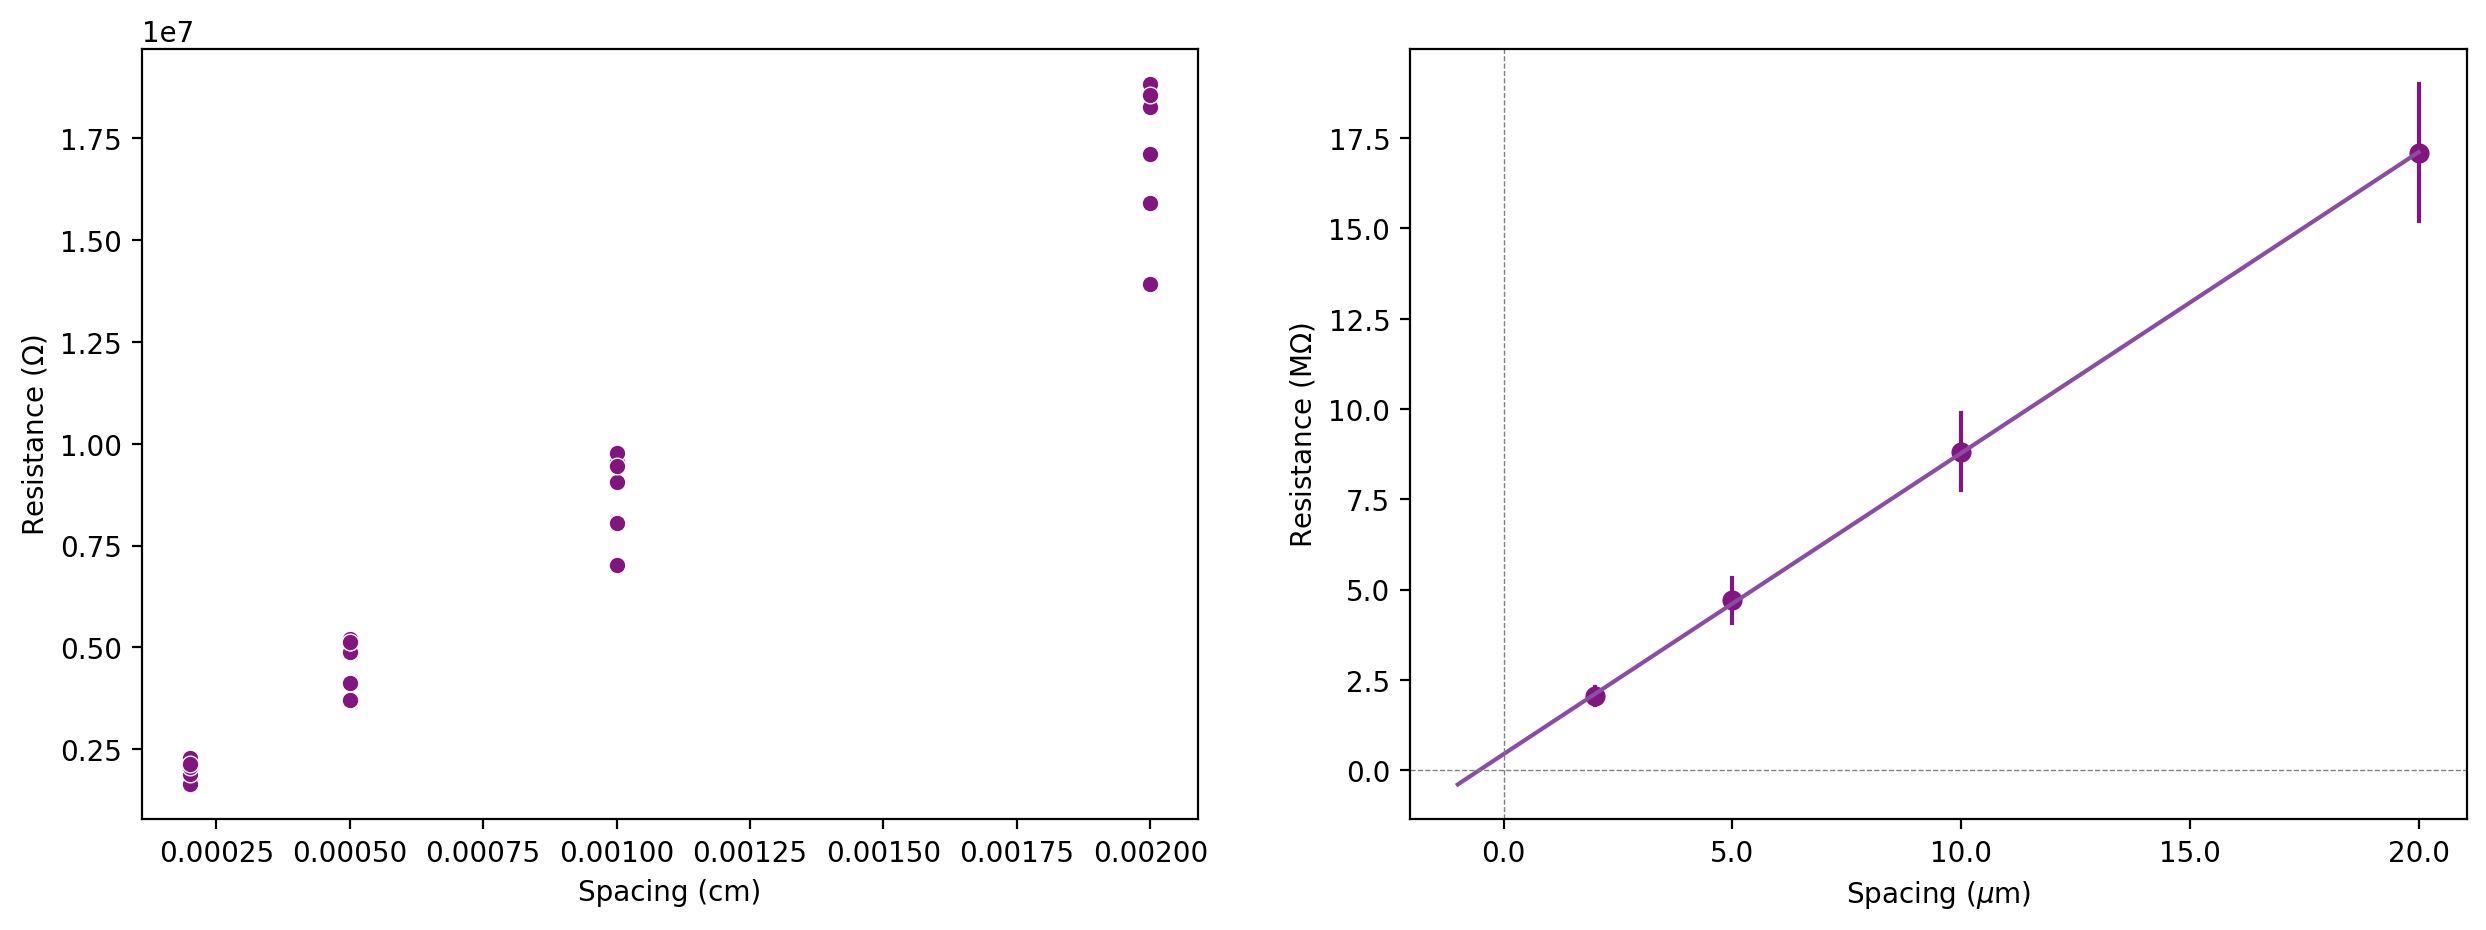

In [44]:
# TI2_01
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Contact Resistance\IDEA2_TLM\LMO_Pt'
sample = 'LMO/Pt'
TI2_01, TI2_01_fit, TI2_01_fit_vals= C_R(path, sample)

  Structure  Spacing (cm)  Resistance ($\Omega$)    Sample
0       P01        0.0002           1.092187e+06  LMO/C/Pt
1       P02        0.0005           1.735653e+06  LMO/C/Pt
2       P03        0.0010           2.817861e+06  LMO/C/Pt
3       P04        0.0020           4.919248e+06  LMO/C/Pt
[[Model]]
    Model(tlm2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 231
    # data points      = 4
    # variables        = 2
    chi-square         = 2.6366e+08
    reduced chi-square = 1.3183e+08
    Akaike info crit   = 76.0155685
    Bayesian info crit = 74.7881572
    R-squared          = 0.99996876
[[Variables]]
    r_s:  8.1735e+10 +/- 3.2180e+08 (0.39%) (init = 1000000)
    N:    60 (fixed)
    w:    0.0005 (fixed)
    L:    0.32 (fixed)
    l_t:  1.5624e-04 +/- 2.7769e-06 (1.78%) (init = 1e-05)
[[Correlations]] (unreported correlations are < 0.100)
    C(r_s, l_t) = -0.875
Contact Resistivity = 2000.9570533669532 Ohm cm2
LMO conductivity = 3.55398170433

c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\axes\_axes.py:1180: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\axes\_axes.py:1181: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


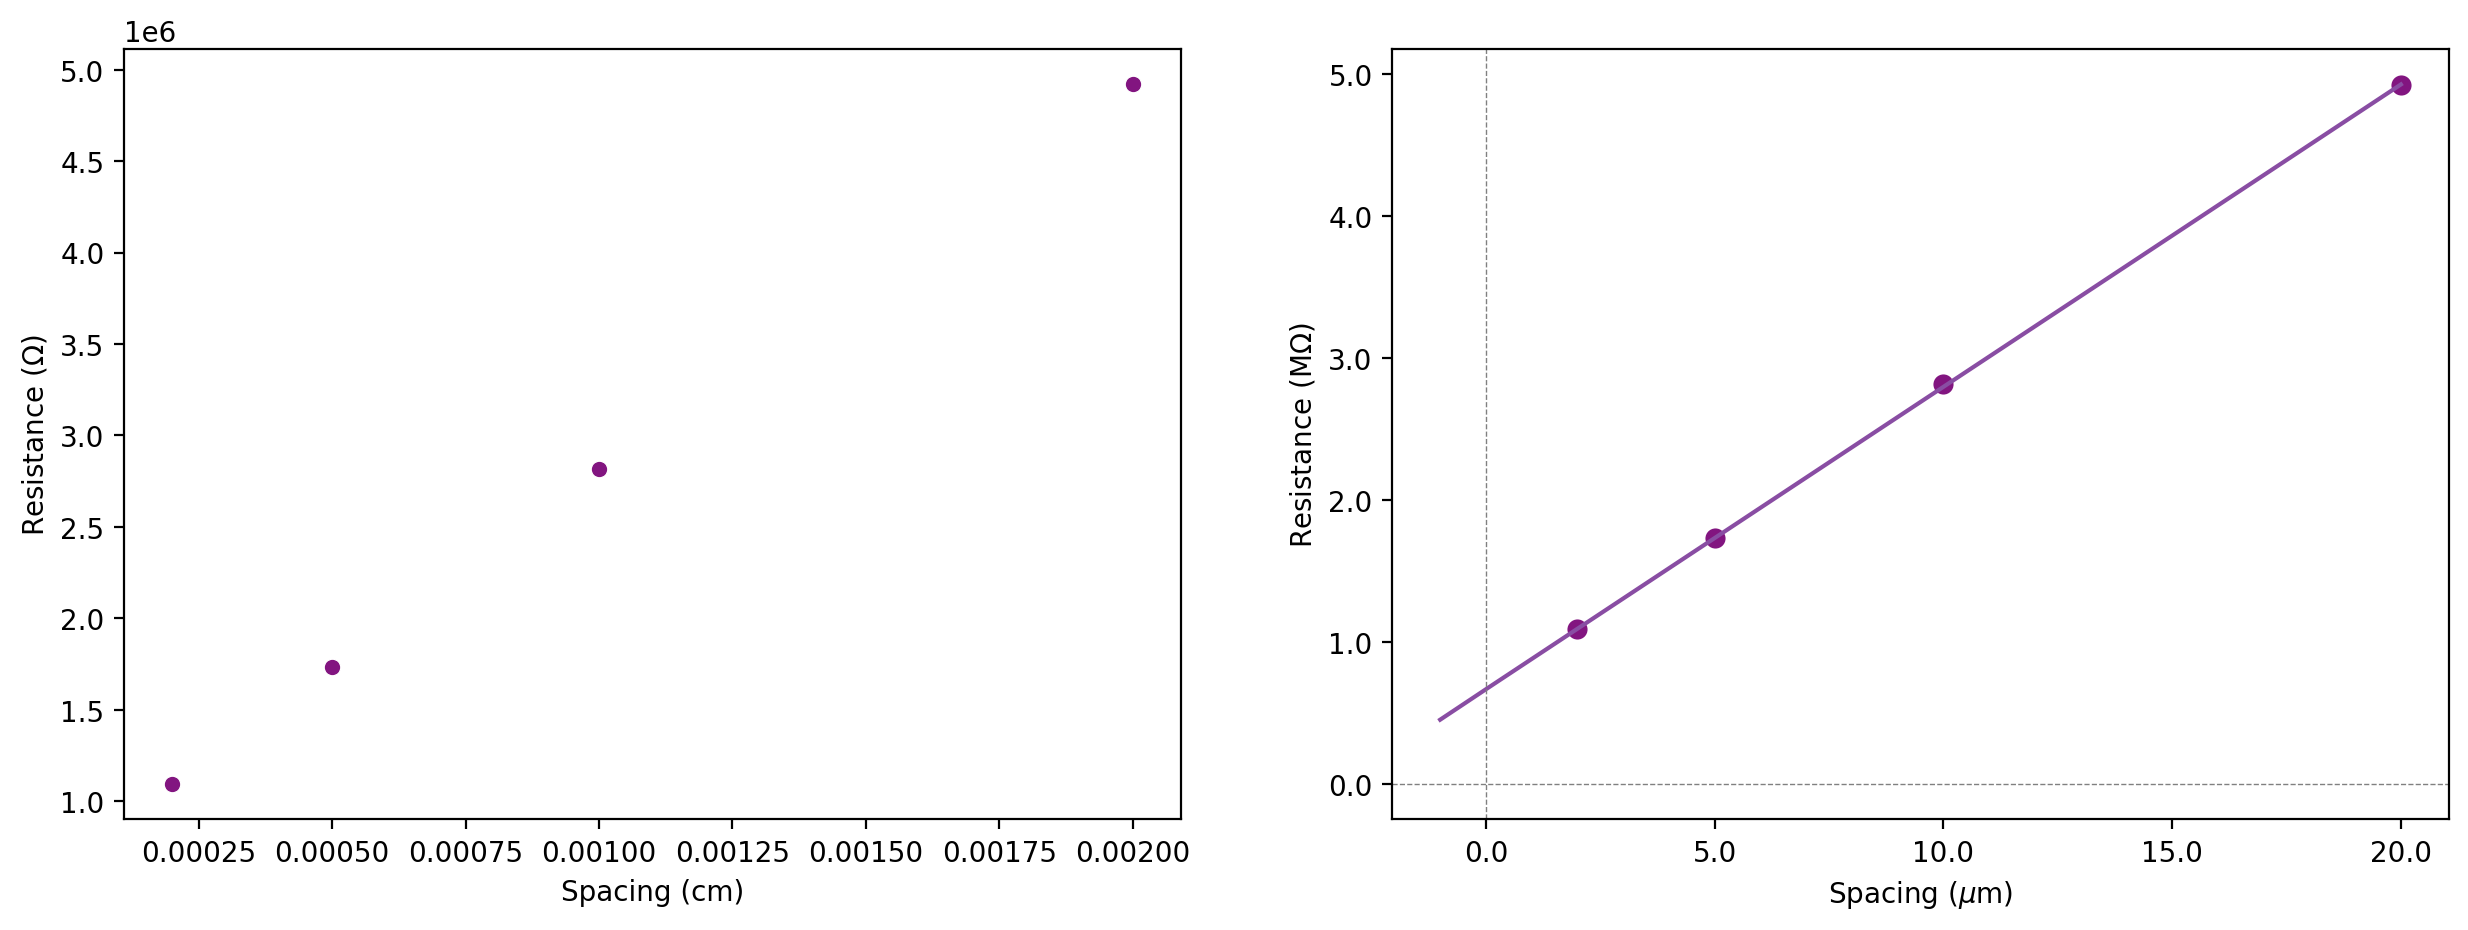

In [45]:
# LMO/C/Pt
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Contact Resistance\IDEA2_TLM\LMO_C_Pt'
sample = 'LMO/C/Pt'
lmo_c_pt, lmo_c_pt_fit, lmo_c_pt_fit_vals = C_R(path, sample)

In [36]:
lmo_c_pt_fit_vals

{'rc': 334824.6316497265,
 'lt': 0.00015623850572499265,
 'p_c': 2000.9570533669532,
 'sigma': 3.55398170433961e-08}

{'r_s': 319927570368.636, 'rc': 221338.90061784754, 'lt': 2.6386802674860377e-05, 'p_c': 223.39672851086019, 'sigma': 9.079742489253858e-09}
{'r_s': 81735366015.3304, 'rc': 334824.6316497265, 'lt': 0.00015623850572499265, 'p_c': 2000.9570533669532, 'sigma': 3.55398170433961e-08}


c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\axes\_axes.py:1180: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\axes\_axes.py:1181: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


Text(0, 0.5, 'Resistance (M$\\Omega$)')

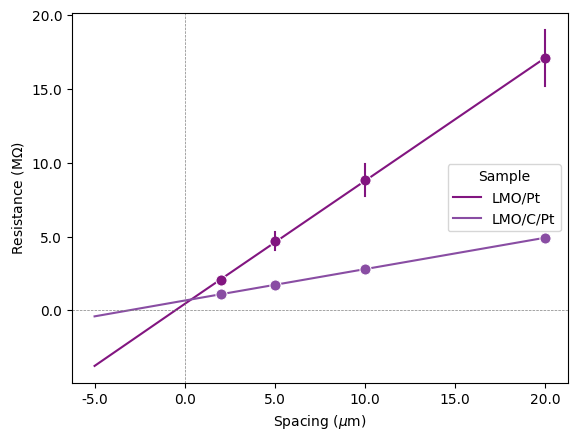

In [46]:
# Compare
cross_zero = np.array([-5, 0, 20]) * 1e-4
    # y_zero = tlm_mod2.eval(tlm_fit2.params, s = cross_zero)

vals = pd.concat([TI2_01, lmo_c_pt], ignore_index = True)
fit = [TI2_01_fit, lmo_c_pt_fit]
fit_val = [TI2_01_fit_vals, lmo_c_pt_fit_vals]


fig, ax = plt.subplots(dpi = 100)

for i in fit:
    y_zero = tlm_mod2.eval(i.params, s = cross_zero)
    sns.lineplot(x = cross_zero, y = y_zero)

for i in fit_val:
    print(i)

sns.lineplot(data = vals, x = col2[1], y = col2[2], marker='o', markersize = 8, errorbar='sd',err_style='bars', linestyle='', hue = 'Sample')

plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)  # Horizontal zero line
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)  # Vertical zero line

ax.yaxis.set_major_formatter(formatter)
ax.xaxis.set_major_formatter(formatter_1)

ax.set_xlabel('Spacing ($\mu$m)')
ax.set_ylabel('Resistance (M$\Omega$)')
# TI2_01_fit.params
# vals